In [ ]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [ ]:

!pip3 install statsmodels

In [ ]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from scipy.stats import norm
import statsmodels.api as sm

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:

import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
! pip3 install textblob
from textblob import TextBlob

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
!pip3 install lightgbm
import lightgbm

In [ ]:
!pip3 install pmdarima

In [ ]:
df_prices = pd.read_csv('/content/^BSESN.csv')
df_prices.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-01-03,6626.490234,6684.220215,6626.490234,6679.200195,6679.200195,12000.0
1,2005-01-04,6683.560059,6696.310059,6640.899902,6651.009766,6651.009766,16600.0
2,2005-01-05,6628.890137,6629.979980,6337.609863,6458.839844,6458.839844,24000.0
3,2005-01-06,6447.270020,6481.229980,6325.359863,6367.390137,6367.390137,22200.0
4,2005-01-07,6374.189941,6440.169922,6348.750000,6420.459961,6420.459961,17800.0


In [ ]:
len(df_prices)

3682

In [ ]:
df_prices['Date'] = pd.to_datetime(df_prices['Date'])
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3682 entries, 0 to 3681
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3682 non-null   datetime64[ns]
 1   Open       3655 non-null   float64       
 2   High       3655 non-null   float64       
 3   Low        3655 non-null   float64       
 4   Close      3655 non-null   float64       
 5   Adj Close  3655 non-null   float64       
 6   Volume     3655 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 201.5 KB


In [ ]:
df_prices.dropna(inplace = True)
print(len(df_prices))

3655


Text(0, 0.5, 'BSESN')

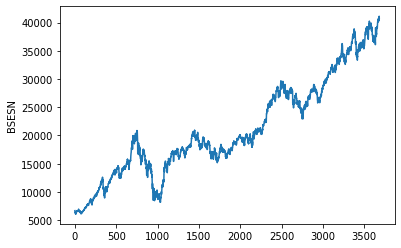

In [ ]:
df_prices['Close'].plot()
plt.ylabel('BSESN')

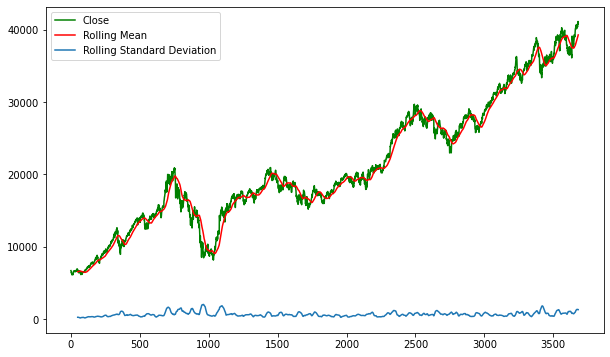

In [ ]:
#Plotting moving average
close = df_prices['Close']
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(10, 6))
df_prices['Close'].plot(color = 'g', label = 'Close')
ma.plot(color = 'r', label = 'Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')
plt.legend()

In [ ]:
# Train test Split

train = df_prices[:3000]
test = df_prices[3000:]

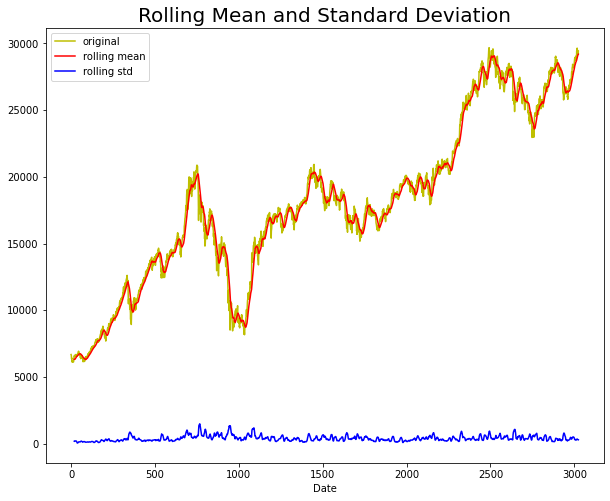

Results of dickey fuller test
ADF Test Statistic : -1.0674427255215448
p-value : 0.7278792554637014
#Lags Used : 5
Number of Observations Used : 2994
Weak evidence against null hypothesis, time series is non-stationary 


In [ ]:
#Stationarity test
def test_stationarity(timeseries):

 #Determing rolling statistics
 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
 plt.figure(figsize = (10,8))
 plt.plot(timeseries, color = 'y', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'b', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 20)
 plt.show(block = False)
 
 print('Results of dickey fuller test')
 result = adfuller(timeseries, autolag = 'AIC')
 labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
 for value,label in zip(result, labels):
   print(label+' : '+str(value) )
 if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Close'])

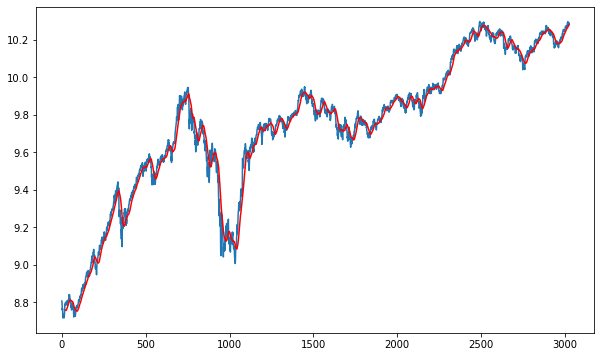

In [ ]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean() 
plt.figure(figsize = (10,6))
plt.plot(train_log) 
plt.plot(mav, color = 'red')

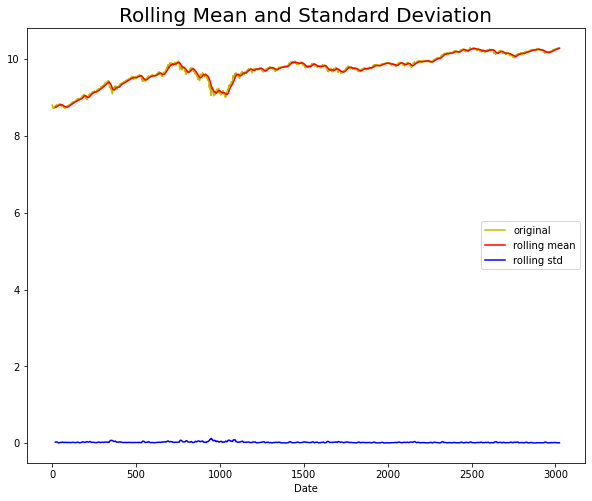

Results of dickey fuller test
ADF Test Statistic : -2.054580281077689
p-value : 0.26316567390877943
#Lags Used : 4
Number of Observations Used : 2995
Weak evidence against null hypothesis, time series is non-stationary 


In [ ]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

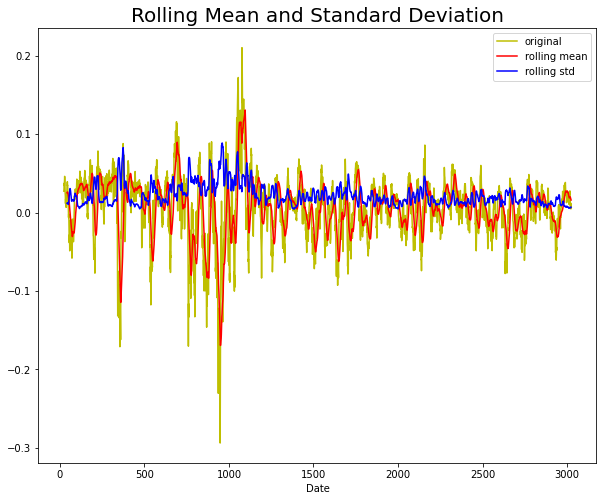

Results of dickey fuller test
ADF Test Statistic : -8.109803873988904
p-value : 1.2345888654263677e-12
#Lags Used : 22
Number of Observations Used : 2954
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [ ]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

**Time series Prediction**

In [ ]:
#Using auto arima to make predictions using log data
from pmdarima import auto_arima
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(n_periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-16732.078, Time=1.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16732.810, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16750.863, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16752.608, Time=1.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16731.492, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16753.137, Time=1.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-16758.005, Time=0.80 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-16755.666, Time=0.61 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-16753.553, Time=1.98 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-16738.810, Time=2.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-16755.762, Time=1.65 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-16747.118, Time=5.61 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-16756.463, Time=0.25 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 17.267 sec

Text(0, 0.5, 'Actual Stock Price')

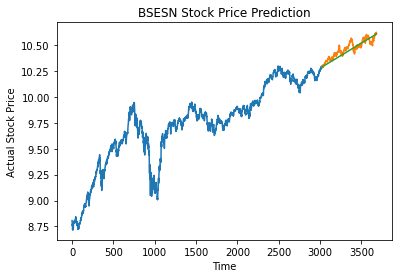

In [ ]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

In [ ]:
#Calculating error
rms = np.sqrt(mean_squared_error(test_log,predictions))
print("RMSE : ", rms)

RMSE :  0.040734095216046


**Textual Analysis**

In [ ]:
cols = ['Date','Category','News']
df_news=pd.read_csv('/content/india-news-headlines.csv',names = cols,engine='python', error_bad_lines=False)
df_news

Skipping line 3328201: unexpected end of data


,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa
...,...,...,...
3328195,20200622,india,MEA tells missions to resume visa services
3328196,20200622,city.lucknow,Use PM Modi's scheme for jobs to migrants: Yog...
3328197,20200622,city.lucknow,Uttar Pradesh: Covid found in staff of 25 of 6...
3328198,20200622,city.lucknow,Kanpur shelter home Covid-19 tally touches 57


In [ ]:
df_news.drop(0, inplace=True)
df_news.drop('Category', axis = 1, inplace=True)
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3328199 entries, 1 to 3328199
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Date    object
 1   News    object
dtypes: object(2)
memory usage: 76.2+ MB


In [ ]:
pd.to_datetime(df_news.iloc[:,0].str.replace('‑','-'),format='%Y%m%d')

1         2001-01-02
2         2001-01-02
3         2001-01-02
4         2001-01-02
5         2001-01-02
             ...    
3328195   2020-06-22
3328196   2020-06-22
3328197   2020-06-22
3328198   2020-06-22
3328199   2020-06-22
Name: Date, Length: 3328199, dtype: datetime64[ns]

In [ ]:
#Converting data type of Date column 
df_news['Date'] = pd.to_datetime(df_news['Date'],errors='coerce', format= '%Y%M%d')
df_news

,Date,News
1,2001-01-02 00:01:00,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-02 00:01:00,Fissures in Hurriyat over Pak visit
3,2001-01-02 00:01:00,America's unwanted heading for India?
4,2001-01-02 00:01:00,For bigwigs; it is destination Goa
5,2001-01-02 00:01:00,Extra buses to clear tourist traffic
...,...,...
3328195,2020-01-22 00:06:00,MEA tells missions to resume visa services
3328196,2020-01-22 00:06:00,Use PM Modi's scheme for jobs to migrants: Yog...
3328197,2020-01-22 00:06:00,Uttar Pradesh: Covid found in staff of 25 of 6...
3328198,2020-01-22 00:06:00,Kanpur shelter home Covid-19 tally touches 57


In [ ]:
#Grouping the headlines for each day
df_news['News'] = df_news.groupby(['Date']).transform(lambda x : ' '.join(x)) 
df_news = df_news.drop_duplicates() 
df_news.reset_index(inplace = True, drop = True)
df_news

,Date,News
0,2001-01-02 00:01:00,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03 00:01:00,Powerless north India gropes in the dark Think...
2,2001-01-04 00:01:00,The string that pulled Stephen Hawking to Indi...
3,2001-01-05 00:01:00,Light combat craft takes India into club class...
4,2001-01-06 00:01:00,Light combat craft takes India into club class...
...,...,...
7065,2020-01-18 00:06:00,Three killed in two road accidents Two detaine...
7066,2020-01-19 00:06:00,Bengaluru: Motorist who drove with cabbie on b...
7067,2020-01-20 00:06:00,City's private hospital allowed to treat coron...
7068,2020-01-21 00:06:00,Guest workers continue to throng Central rly s...


In [ ]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [ ]:
#Adding subjectivity and polarity columns
df_news['Subjectivity'] = df_news['News'].apply(getSubjectivity)
df_news['Polarity'] = df_news['News'].apply(getPolarity)
df_news

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,News,Subjectivity,Polarity
0,2001-01-02 00:01:00,Status quo will not be disturbed at Ayodhya; s...,0.282333,0.151333
1,2001-01-03 00:01:00,Powerless north India gropes in the dark Think...,0.407692,0.088462
2,2001-01-04 00:01:00,The string that pulled Stephen Hawking to Indi...,0.446847,0.087961
3,2001-01-05 00:01:00,Light combat craft takes India into club class...,0.476612,0.262024
4,2001-01-06 00:01:00,Light combat craft takes India into club class...,0.439394,0.248485
...,...,...,...,...
7065,2020-01-18 00:06:00,Three killed in two road accidents Two detaine...,0.413730,0.062539
7066,2020-01-19 00:06:00,Bengaluru: Motorist who drove with cabbie on b...,0.383824,0.053581
7067,2020-01-20 00:06:00,City's private hospital allowed to treat coron...,0.395501,0.078785
7068,2020-01-21 00:06:00,Guest workers continue to throng Central rly s...,0.404802,0.072493


In [ ]:

#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()

df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['News']]
df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['News']]
df_news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df_news['News']]
df_news['Positive'] = [sia.polarity_scores(v)['pos'] for v in df_news['News']]
df_news

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02 00:01:00,Status quo will not be disturbed at Ayodhya; s...,0.282333,0.151333,-0.9811,0.122,0.807,0.071
1,2001-01-03 00:01:00,Powerless north India gropes in the dark Think...,0.407692,0.088462,-0.2640,0.122,0.766,0.111
2,2001-01-04 00:01:00,The string that pulled Stephen Hawking to Indi...,0.446847,0.087961,0.8738,0.100,0.797,0.103
3,2001-01-05 00:01:00,Light combat craft takes India into club class...,0.476612,0.262024,0.9633,0.124,0.722,0.154
4,2001-01-06 00:01:00,Light combat craft takes India into club class...,0.439394,0.248485,-0.4215,0.152,0.704,0.143
...,...,...,...,...,...,...,...,...
7065,2020-01-18 00:06:00,Three killed in two road accidents Two detaine...,0.413730,0.062539,-0.9998,0.136,0.781,0.083
7066,2020-01-19 00:06:00,Bengaluru: Motorist who drove with cabbie on b...,0.383824,0.053581,-0.9999,0.152,0.765,0.083
7067,2020-01-20 00:06:00,City's private hospital allowed to treat coron...,0.395501,0.078785,-0.9999,0.136,0.789,0.075
7068,2020-01-21 00:06:00,Guest workers continue to throng Central rly s...,0.404802,0.072493,-0.9999,0.165,0.744,0.092


In [ ]:
df_merge = pd.merge(df_prices, df_news, how='inner', on='Date')
df_merge

,Date,Open,High,Low,Close,Adj Close,Volume,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive


In [ ]:
exog_data = df_merge[['Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral','Positive']]
exog_data

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive


In [ ]:
df_time_series = df_merge['Close']

In [ ]:
df_time_series

Series([], Name: Close, dtype: float64)

In [ ]:
final_train_data = df_time_series[:3000]
exog_train_data = exog_data[:3000]

final_test_data = df_time_series[3000:]
exog_test_data = exog_data[3000:]